In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import space as sp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib import colors
from sklearn.metrics import adjusted_rand_score as ARI
%matplotlib inline

/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/torch_geometric/typing.py:47: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/torch_geometric/typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.27' not found (required by /home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/torch_spline_conv/_basis_cuda.so)
  warnings.warn(
/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/torch_geometric/typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disablin

In [ ]:
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["figure.dpi"] = 200
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=120,dpi_save=300,facecolor='w',frameon=True,figsize=(4,4)) 
%config InlineBackend.figure_format='retina'
%matplotlib inline

scanpy==1.9.6 anndata==0.10.3 umap==0.5.4 numpy==1.23.4 scipy==1.11.3 pandas==2.1.1 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10


In [ ]:
featurePlotCols=["lightgrey","whitesmoke","#ffffcc","#ffeda0","#fed976","#feb24c","#fd8d3c","#fc4e2a","#e31a1c","#bd0026","#800026","#800026"]
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap',featurePlotCols,N=512)

In [ ]:
sp.__version__

'0.6.9'

In [ ]:
import torch
torch.set_num_threads(10)

## Plot Functions

In [ ]:
def heatmapPlot(data,
                cmap=None,
                fmt = 'd',
                minimum=0,
                figsize=(9.5,7.8),):
    """
    """
    from matplotlib import pyplot as plt
    import seaborn as sns
    %matplotlib inline
    plt.figure(figsize=figsize)
    
    if cmap is None:
        cmap = sns.cubehelix_palette(light=1, as_cmap=True, rot=.3)

    sns.set(font_scale=1.5)
    ax = sns.heatmap(data,
                     xticklabels=1,
                     yticklabels=1,
                     cmap=cmap, vmin=minimum,
                     cbar_kws={"shrink": 1})
#     plt.xticks() 
    fmt = fmt
    thresh = data.max().max() / 1.5
    import itertools
    for i, j in itertools.product(range(data.shape[0]), range(data.shape[1])):
        if data.iloc[i, j] > minimum:
            plt.text(j+0.5, i+0.62, format(data.iloc[i, j], fmt),
                 ha='center', 
                 va='bottom',
                 fontsize=8,
                 color="white" if data.iloc[i, j] > thresh else "black")

## Load Data

In [9]:
adata = sc.read('/home/zhangjinsong/SPAGAT/SPACE_pkg/MERFISH_slice153-1/slice153-1_annot_refined_sp_adata.h5ad')

In [10]:
adata

AnnData object with n_obs × n_vars = 7409 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'BICCN_cluster_label', 'BICCN_subclass_label', 'BICCN_class_label', 'BICCN_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mouse', 'slice', 'dataset', 'sample', 'subclass', 'subclass_preprocessed', 'leiden_SPACE', 'louvain_SPACE', 'leiden_c8', 'leiden_c5', 'leiden_c0', 'leiden_c0-10-15', 'leiden_c7', 'leiden_c4', 'leiden_c1', 'leiden_c15', 'leiden_c27', 'leiden_c15-27', 'leiden_c23', 'leiden_inh', 'leiden_c0-2', 'celltype_SPACE', 'leiden_c16', 'celltype_SPACE_o

## RUN SPACE

Construct Graph
Average links: 22.05
Load SPACE model
SPACE_Graph(
  (encoder): GAT_Encoder(
    (hidden_layer1): GATv2Conv(254, 128, heads=6)
    (hidden_layer2): GATv2Conv(768, 128, heads=6)
    (conv_z): GATv2Conv(768, 10, heads=6)
  )
  (decoder): InnerProductDecoder()
  (decoder_x): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=254, bias=True)
    (5): ReLU()
  )
)
Train SPACE model


  0%|                                                                                                                                                                                        | 0/3001 [00:00<?, ?it/s]/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/space/train.py:142: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_loss=pd.concat([df_loss,pd.Series({'feature_loss':loss2,'graph_loss':loss1,'epoch':epoch}).to_frame().T],ignore_index=True)
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2173/3001 [12:31<04:46,  2.89it/s]

====> Epoch: 2173, Loss: 17.9199
EarlyStopping: run 2173 iteration


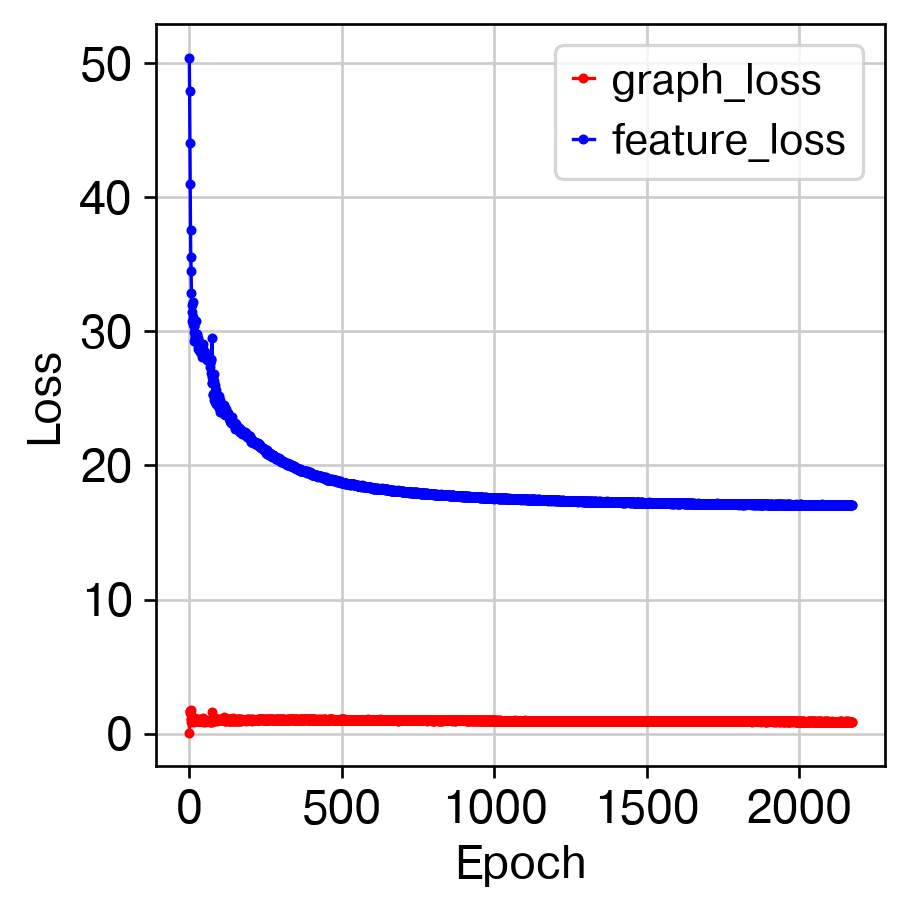

In [9]:
adata=sp.SPACE(adata=adata, outdir='MERFISH_slice153-1',alpha=0.05, GPU=8,patience=50, epoch=3000)

In [10]:
sc.tl.leiden(adata,resolution=1,neighbors_key='SPACE',key_added='leiden_SPACE')

In [11]:
adata.obsm['UmapSPACE'] = adata.obsm['X_umap'].copy()

/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vec

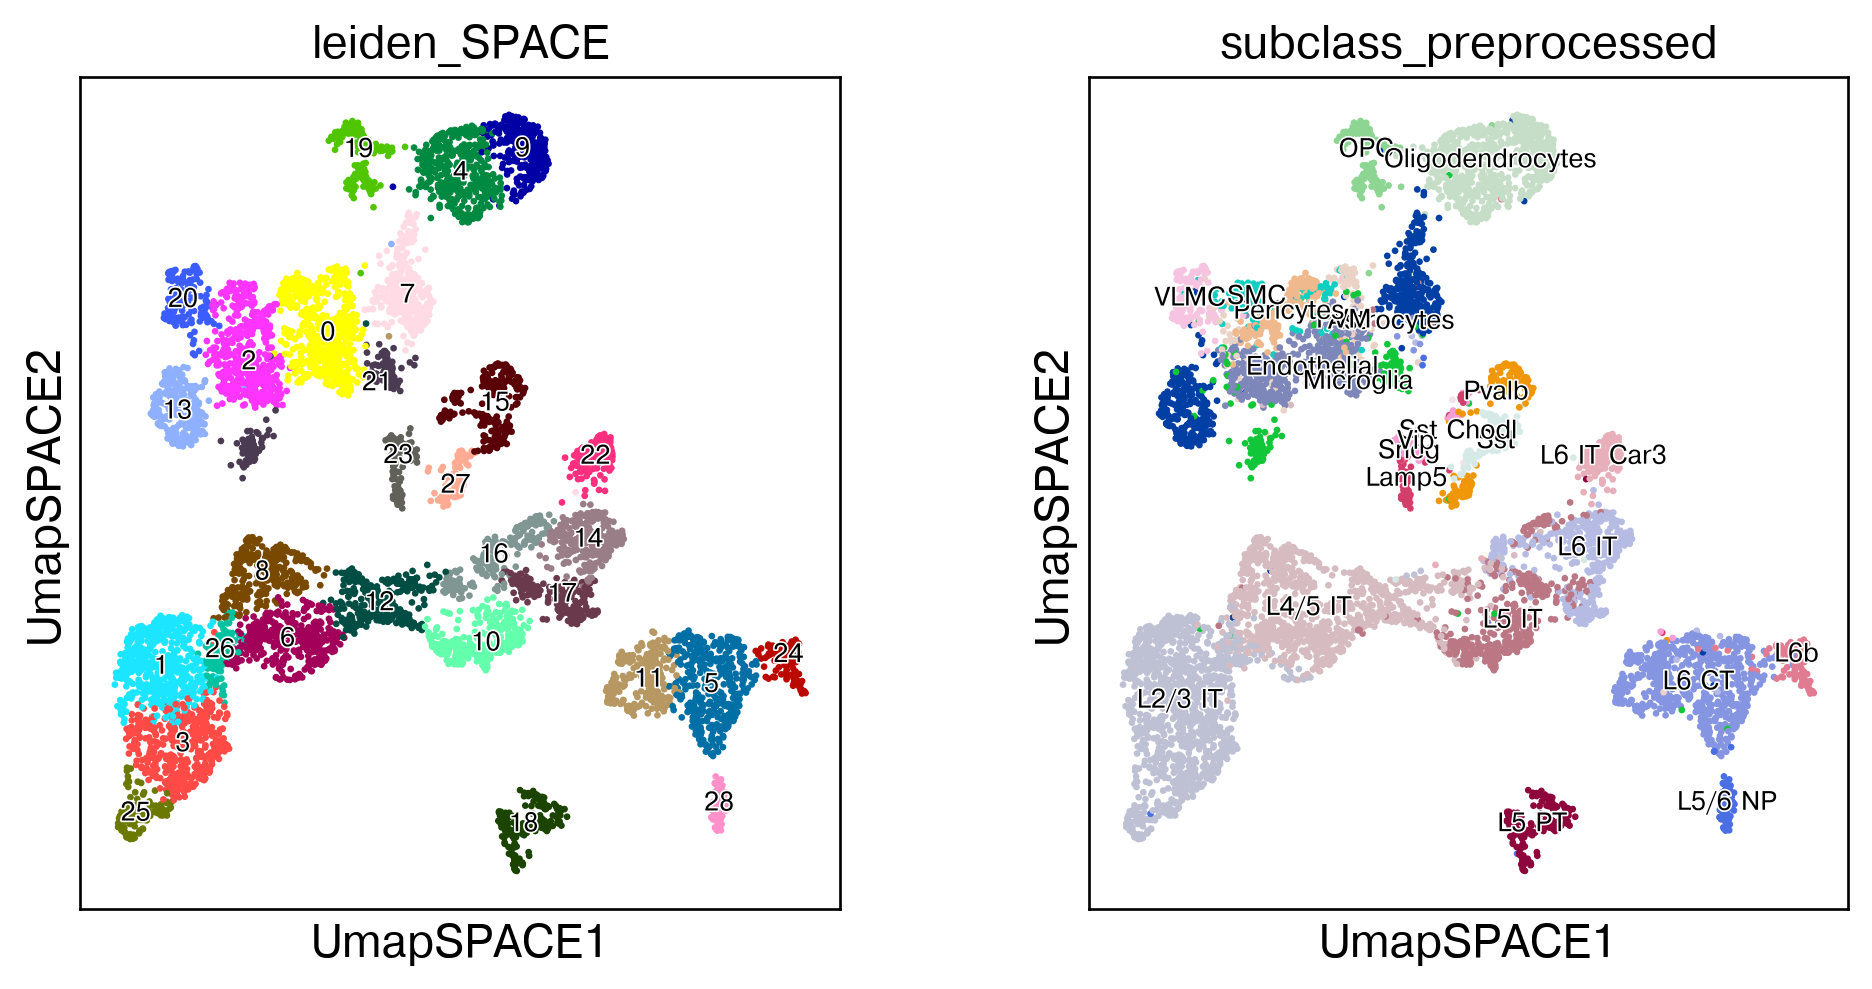

In [11]:
sc.set_figure_params(dpi=120,dpi_save=300,facecolor='w',frameon=True,figsize=(4,4.5)) 
sc.pl.embedding(adata, basis='UmapSPACE',color=['leiden_SPACE','subclass_preprocessed'],legend_loc='on data', legend_fontsize=8, legend_fontoutline=1)

## Annotation

/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vec

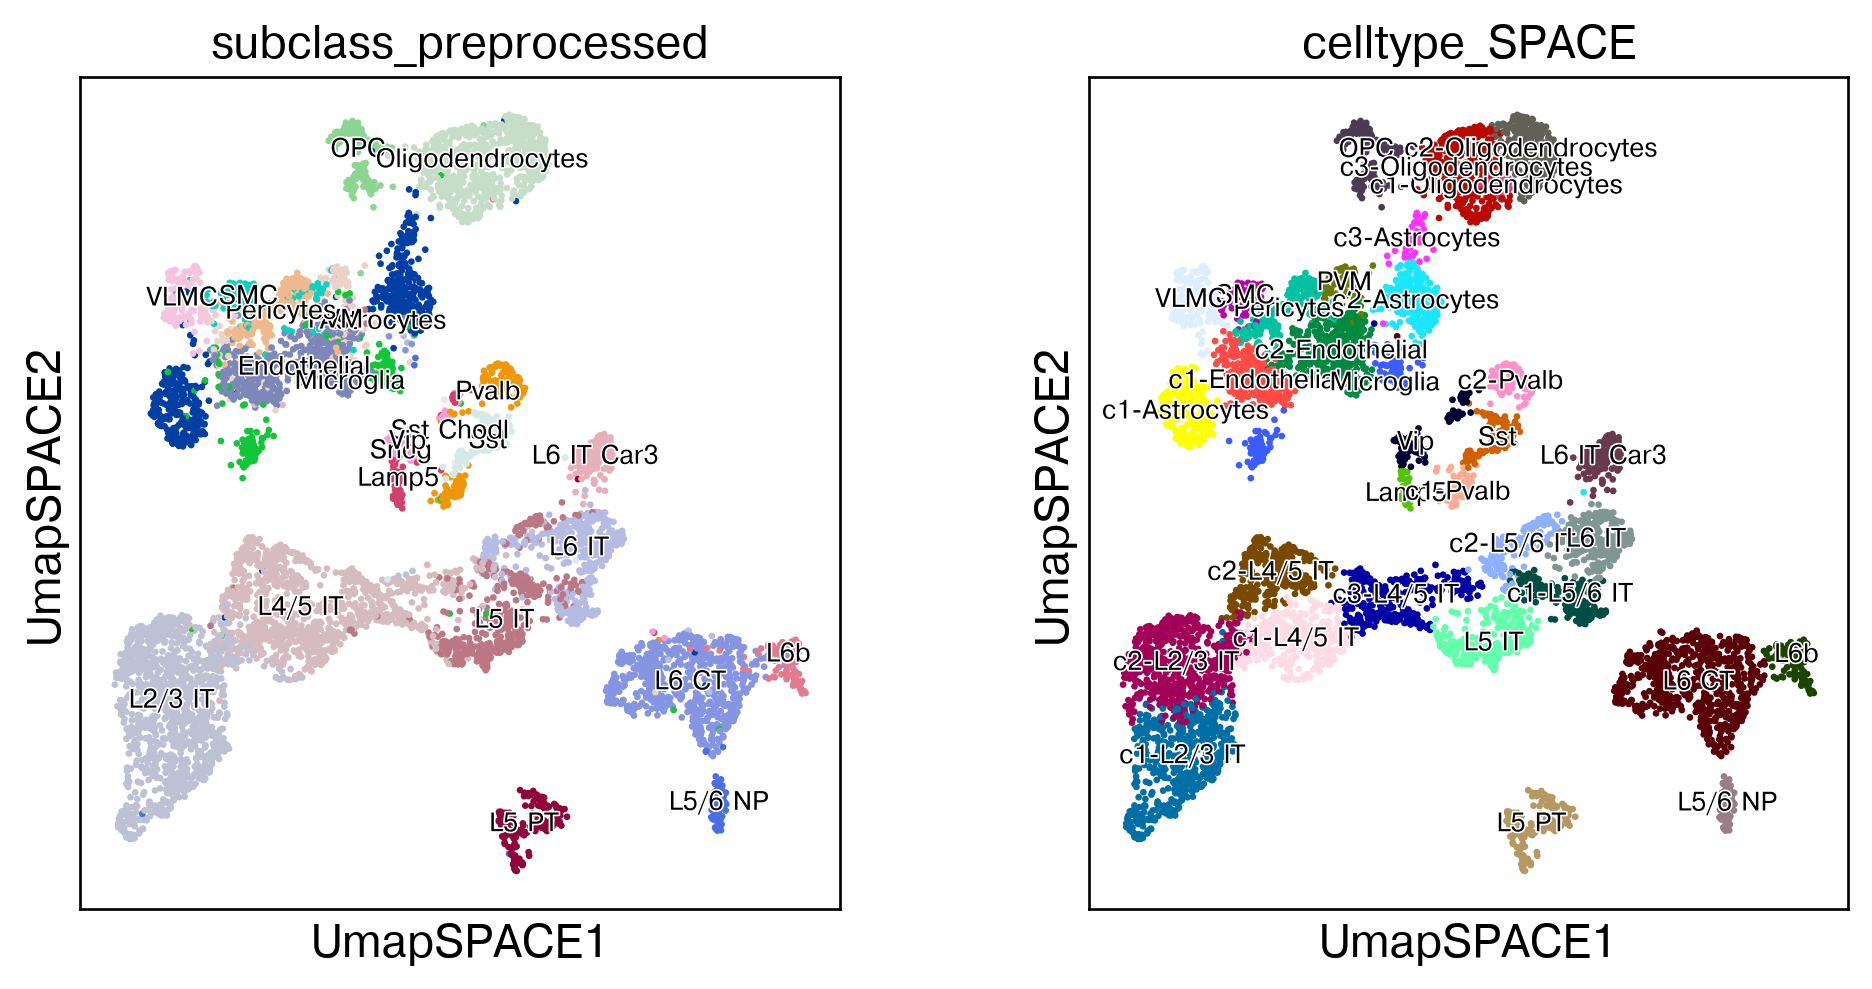

In [13]:
sc.set_figure_params(dpi=120,facecolor='w',frameon=True,figsize=(4,4.5))
sc.pl.embedding(adata,basis='UmapSPACE',color=['subclass_preprocessed','celltype_SPACE'],ncols=2,legend_fontsize=8, legend_loc='on data', legend_fontoutline=1)

## Confusion matrix with original celltype

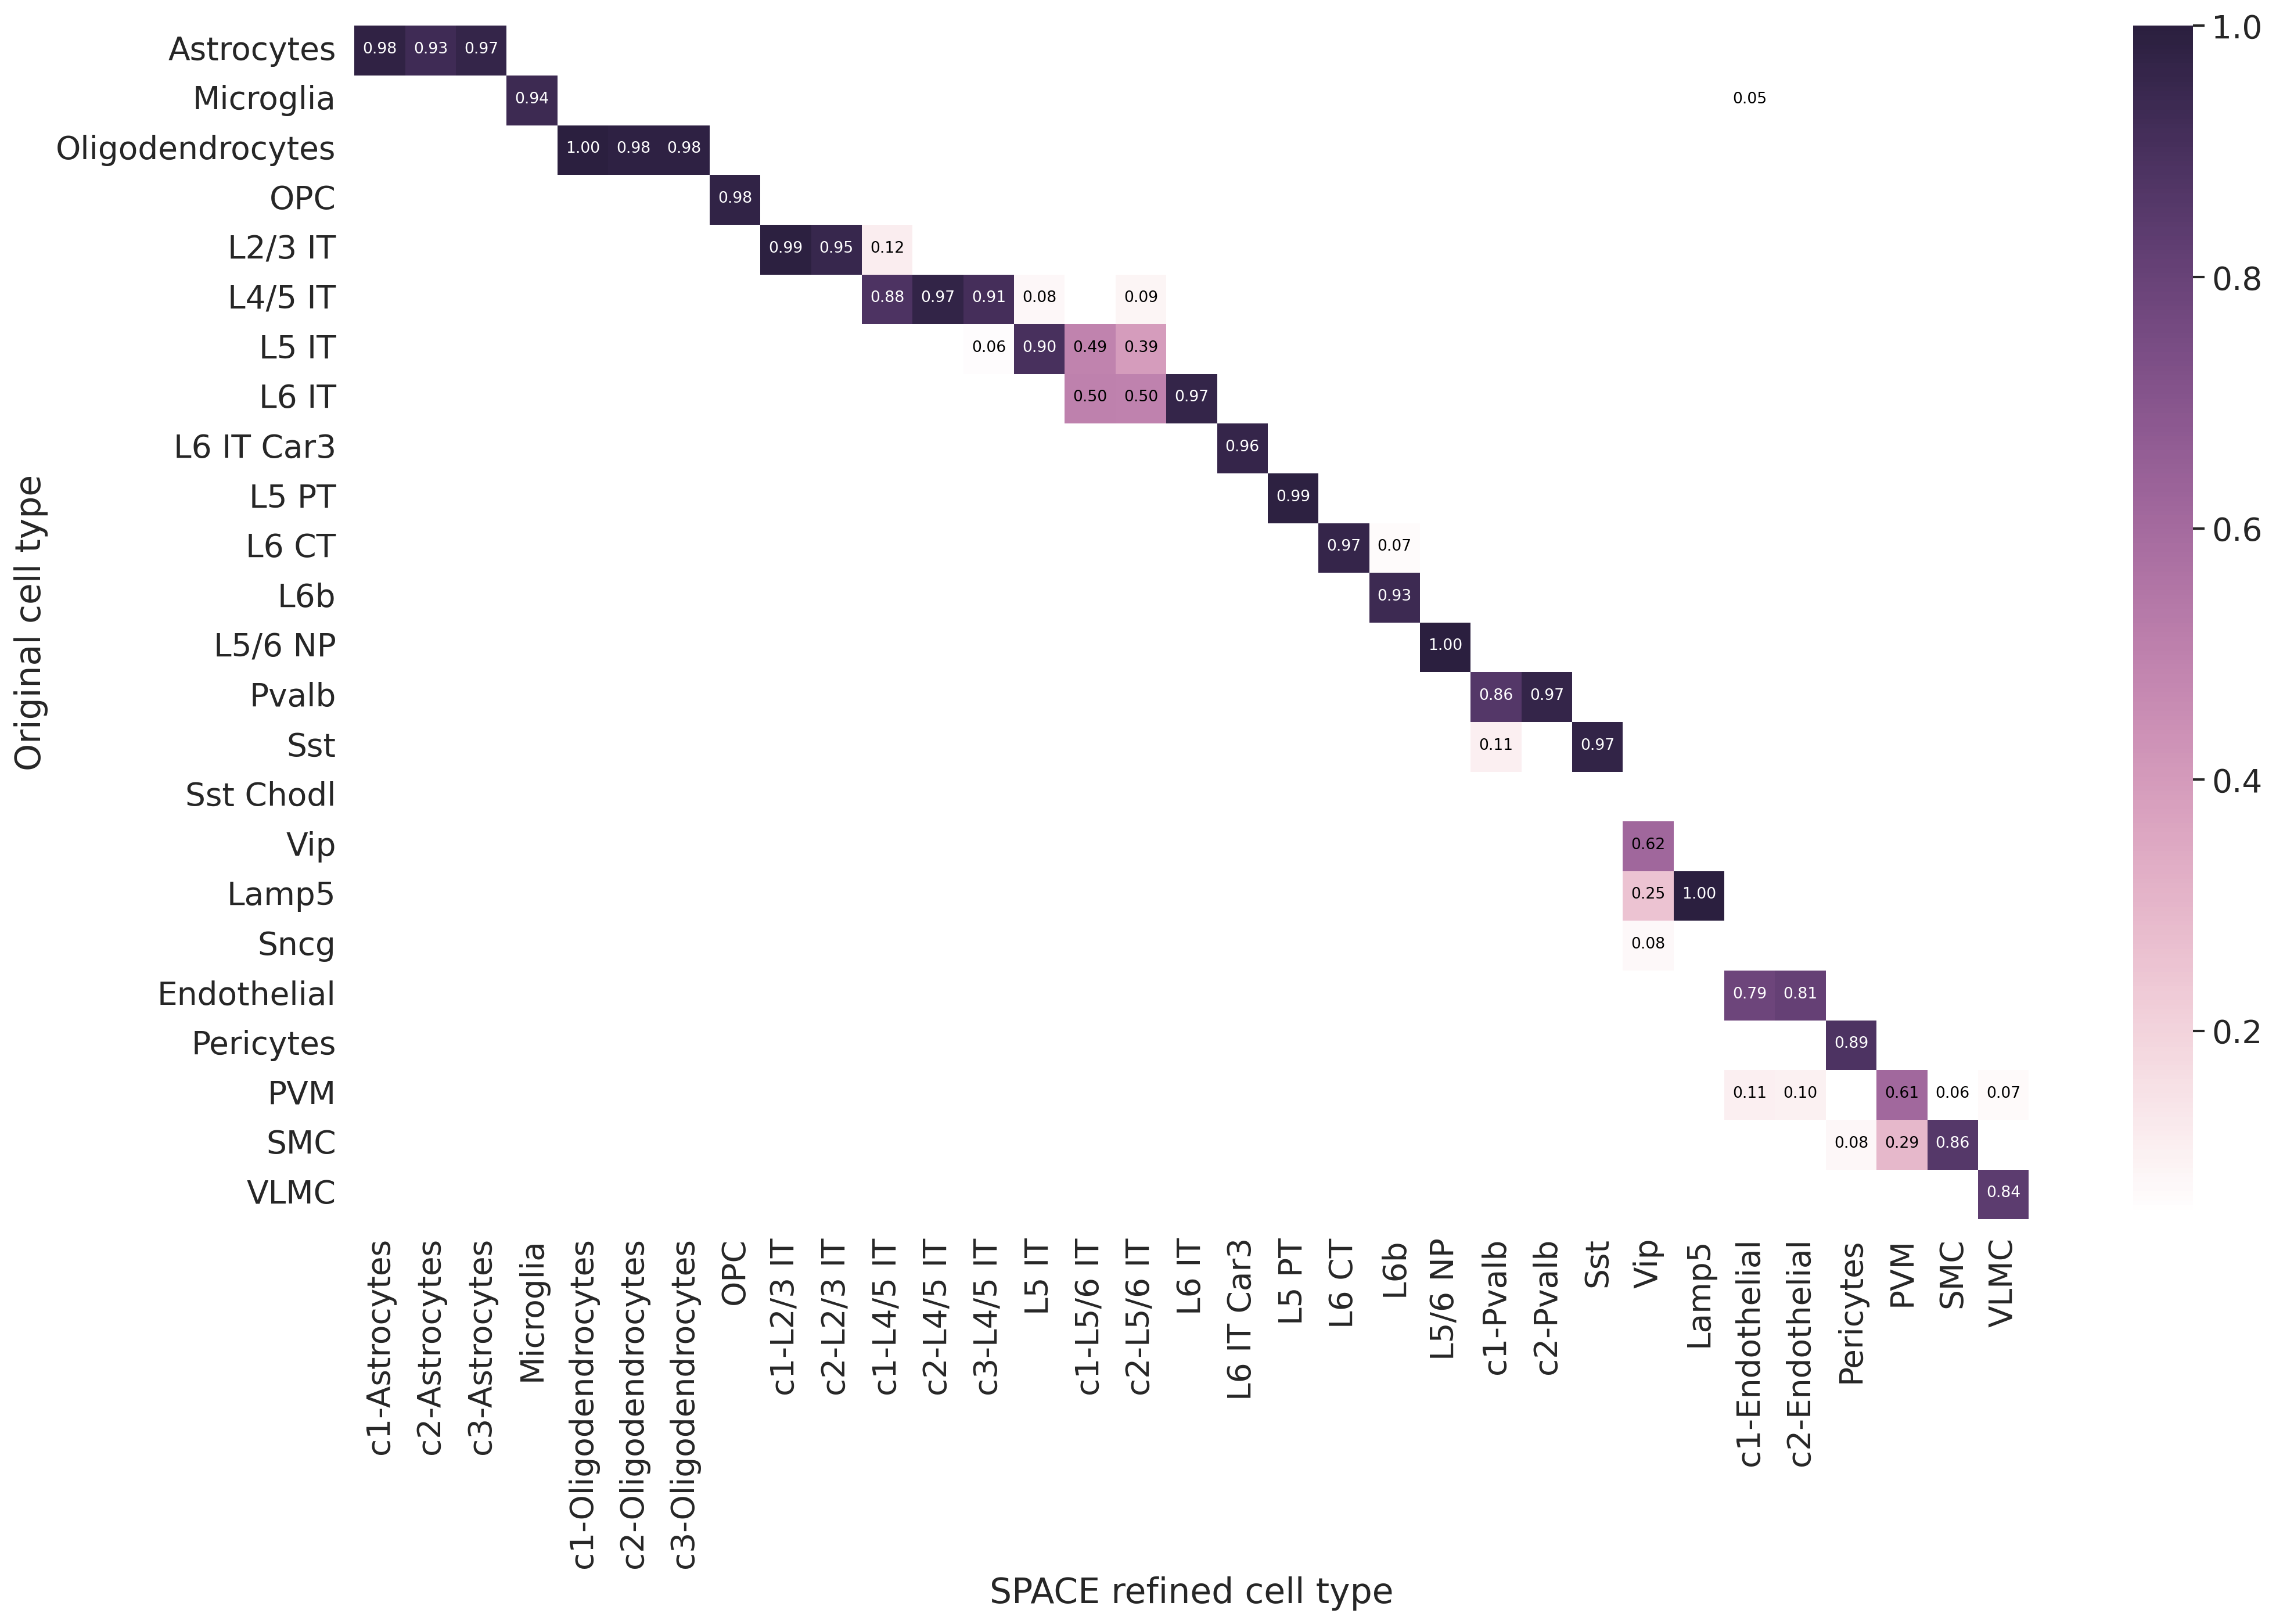

In [14]:
cmtx = sc.metrics.confusion_matrix("celltype_SPACE", "subclass_preprocessed", adata.obs)
y_ordered=['Astrocytes','Microglia','Oligodendrocytes','OPC','L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT', 'L6 IT Car3','L5 PT','L6 CT', 'L6b','L5/6 NP', 'Pvalb', 'Sst','Sst Chodl','Vip','Lamp5','Sncg', 'Endothelial','Pericytes','PVM','SMC','VLMC']
x_ordered=['c1-Astrocytes', 'c2-Astrocytes', 'c3-Astrocytes','Microglia','c1-Oligodendrocytes', 'c2-Oligodendrocytes','c3-Oligodendrocytes','OPC',  'c1-L2/3 IT', 'c2-L2/3 IT', 'c1-L4/5 IT', 'c2-L4/5 IT', 'c3-L4/5 IT', 'L5 IT','c1-L5/6 IT','c2-L5/6 IT', 'L6 IT', 'L6 IT Car3','L5 PT','L6 CT','L6b', 'L5/6 NP',
           'c1-Pvalb','c2-Pvalb','Sst','Vip','Lamp5','c1-Endothelial','c2-Endothelial',
           'Pericytes','PVM','SMC', 'VLMC',]
heatmapPlot(cmtx.T.loc[y_ordered, x_ordered], fmt='0.2f', minimum=0.05, figsize=(18,12))
plt.ylabel('Original cell type')
plt.xlabel('SPACE refined cell type')
plt.tight_layout()
# plt.savefig('./MERFISH_slice153-1/confusion_matrix_bwt_space_and_ori.pdf', dpi=300, bbox_inches='tight')

In [15]:
ARI(adata.obs.subclass_preprocessed.values, adata.obs.celltype_SPACE.values)

0.597624867956563

#### sankey plot

In [11]:
scm=adata.obs.groupby(['subclass_preprocessed','celltype_SPACE']).size().reset_index()
scm.columns = ['source','target','value']

/tmp/ipykernel_29999/2280780624.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scm=adata.obs.groupby(['subclass_preprocessed','celltype_SPACE']).size().reset_index()


In [12]:
adata.uns['celltype_SPACE_colors']

array(['#ffff00', '#1ce6ff', '#ff34ff', '#ff4a46', '#008941', '#006fa6',
       '#a30059', '#ffdbe5', '#7a4900', '#0000a6', '#63ffac', '#b79762',
       '#004d43', '#8fb0ff', '#997d87', '#5a0007', '#809693', '#6a3a4c',
       '#1b4400', '#4fc601', '#3b5dff', '#4a3b53', '#ff2f80', '#61615a',
       '#ba0900', '#6b7900', '#00c2a0', '#ffaa92', '#ff90c9', '#b903aa',
       '#d16100', '#ddefff', '#000035', '#7b4f4b', '#a1c299'],
      dtype=object)

/tmp/ipykernel_29999/2561098115.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scm=adata.obs.groupby(['subclass_preprocessed','celltype_SPACE']).size().reset_index()


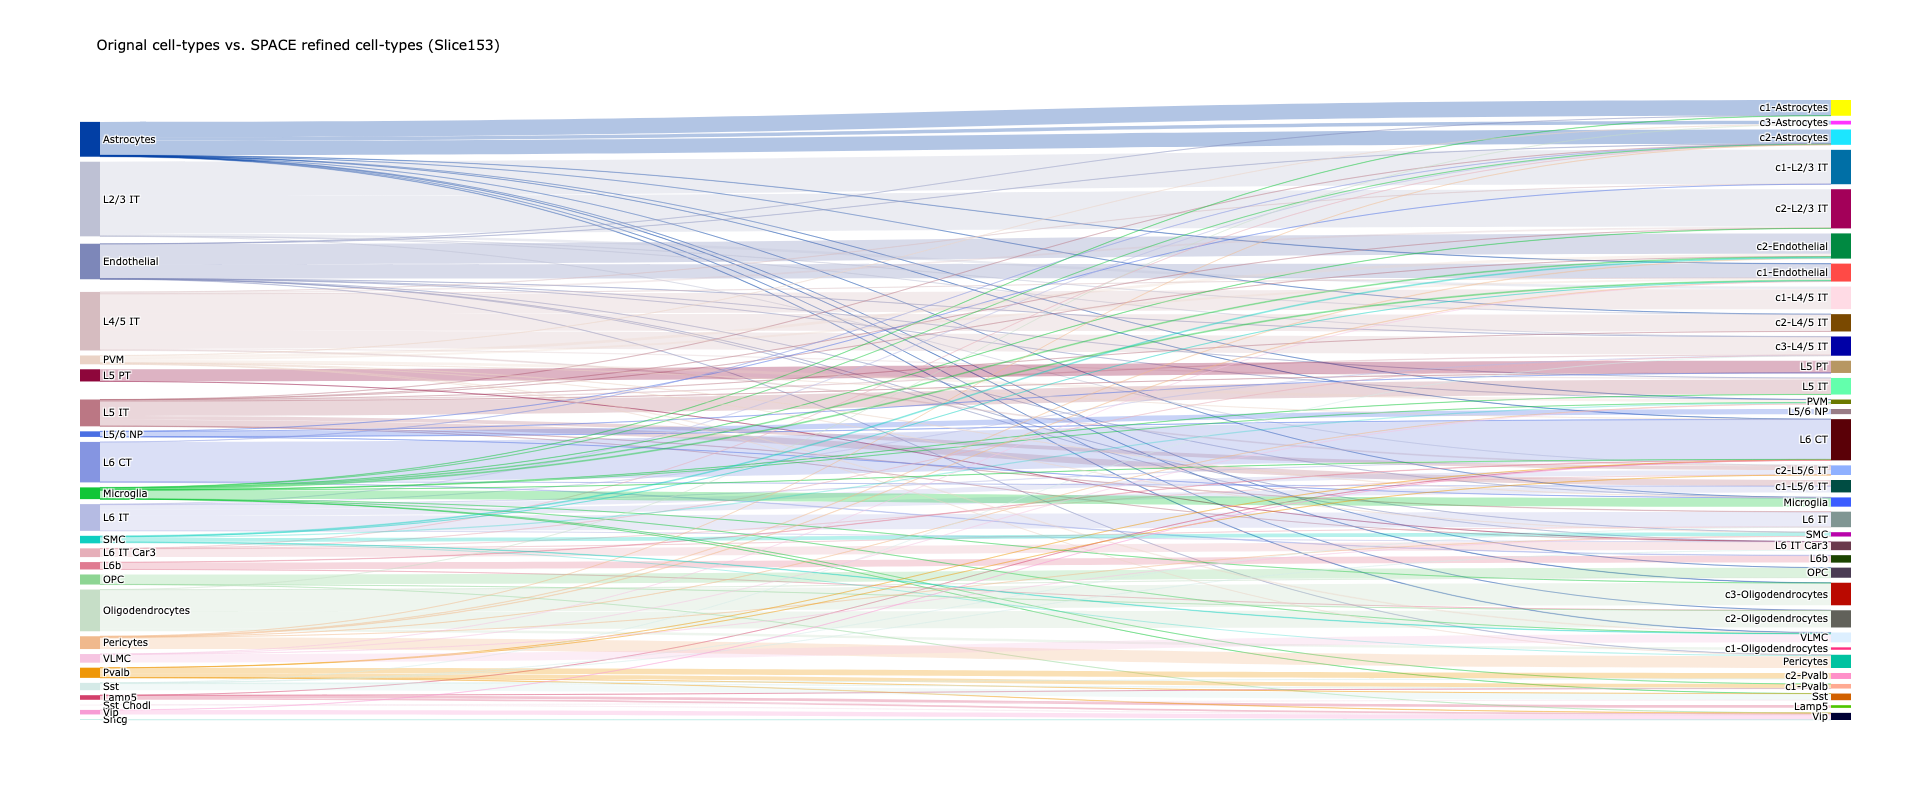

In [13]:
import plotly
import plotly.graph_objects as go


scm=adata.obs.groupby(['subclass_preprocessed','celltype_SPACE']).size().reset_index()
scm.columns = ['source','target','value']

source_index = np.arange(len(scm.source.cat.categories))
target_index = np.arange(len(scm.source.cat.categories), len(scm.source.cat.categories) + len(scm.target.cat.categories))
sources = []
targets = []
for s in source_index:
    sources.extend([s]*len(target_index))
for i in range(len(source_index)): 
    targets.extend(list(target_index))
    
values = scm.value.values

opacity=0.3
source_color_dict = dict(zip(list(adata.obs.subclass_preprocessed.cat.categories), list(adata.uns['subclass_preprocessed_colors'])))
link_colors = []
for i in scm.source.values:
    r,g,b,a = colors.to_rgba(source_color_dict[i], alpha=opacity)
    color_code = 'rgba({},{},{},{})'.format(r*255.0,g*255.0,b*255.0,a)
    link_colors.append(color_code)

fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    node = dict(
      pad = 5,
      thickness = 20,
      line = dict(color = "black", width = 0),
      label = list(scm.source.cat.categories) + list(scm.target.cat.categories),# ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = list(adata.uns['subclass_preprocessed_colors']) + list(adata.uns['celltype_SPACE_colors'])
    ),
    link = dict(
      source = sources,#[0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = targets,#[2, 3, 3, 4, 4, 5],
      value = values,
      color = link_colors #[8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Orignal cell-types vs. SPACE refined cell-types (Slice153)", 
#                   font_family="Helvetica",
                  font_color="black",
                  font_size=10,
                  autosize=False,
                  width=600,
                  height=800,
)
fig.show()
fig.write_image(os.path.join(sc.settings.figdir,'celltype_sankey.pdf'))

## Umap and Spatial

/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



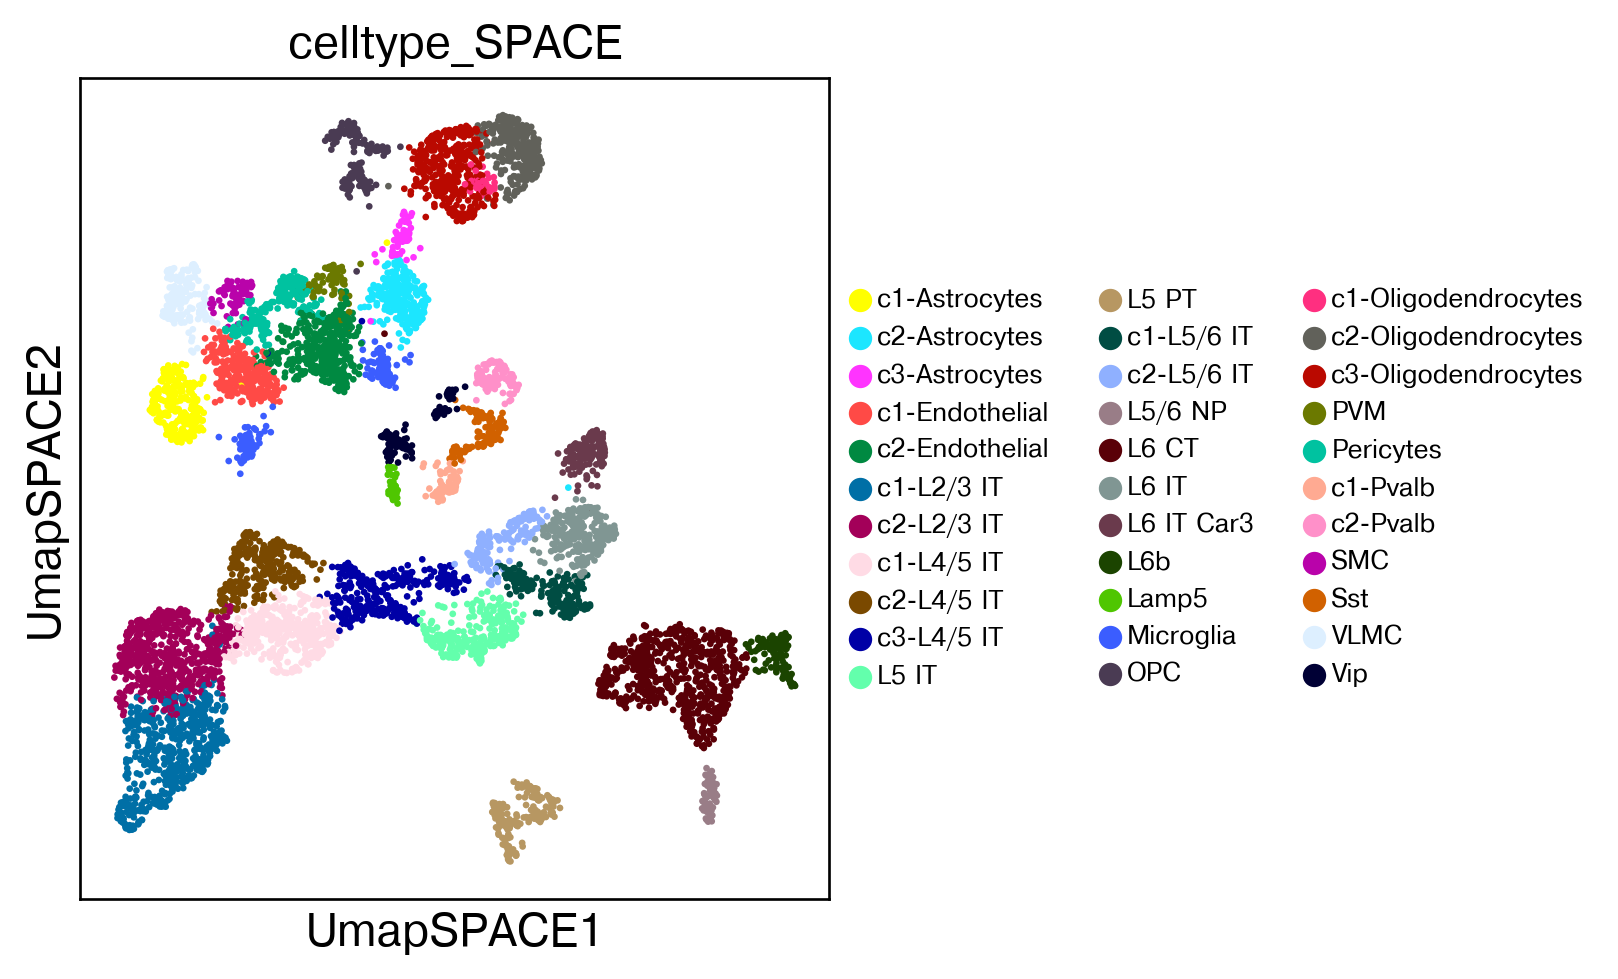

In [14]:
sc.set_figure_params(dpi=120,dpi_save=300,facecolor='w',frameon=True,figsize=(4,4.5)) 
sc.pl.embedding(adata,basis='UmapSPACE',color=['celltype_SPACE'],legend_fontsize=8,save='_celltype_SPACE.pdf')

/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



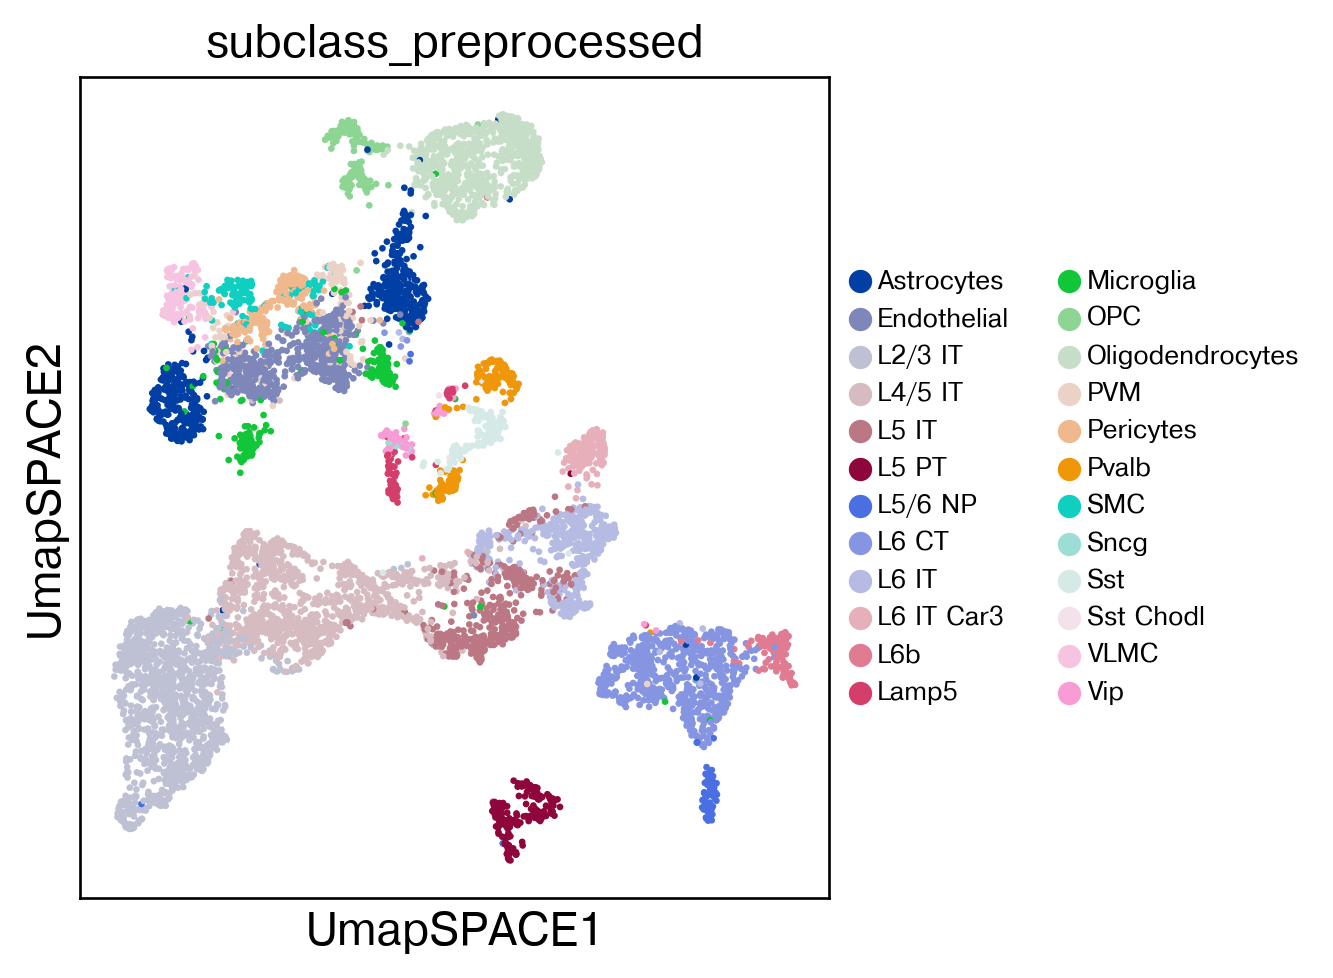

In [15]:
sc.set_figure_params(dpi=120,dpi_save=300,facecolor='w',frameon=True,figsize=(4,4.5)) 
sc.pl.embedding(adata,basis='UmapSPACE',color=['subclass_preprocessed'],legend_fontsize=8,save='_subclass.pdf')

## Astrocytes subtypes

/home/zhangjinsong/anaconda3/envs/space-srt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning



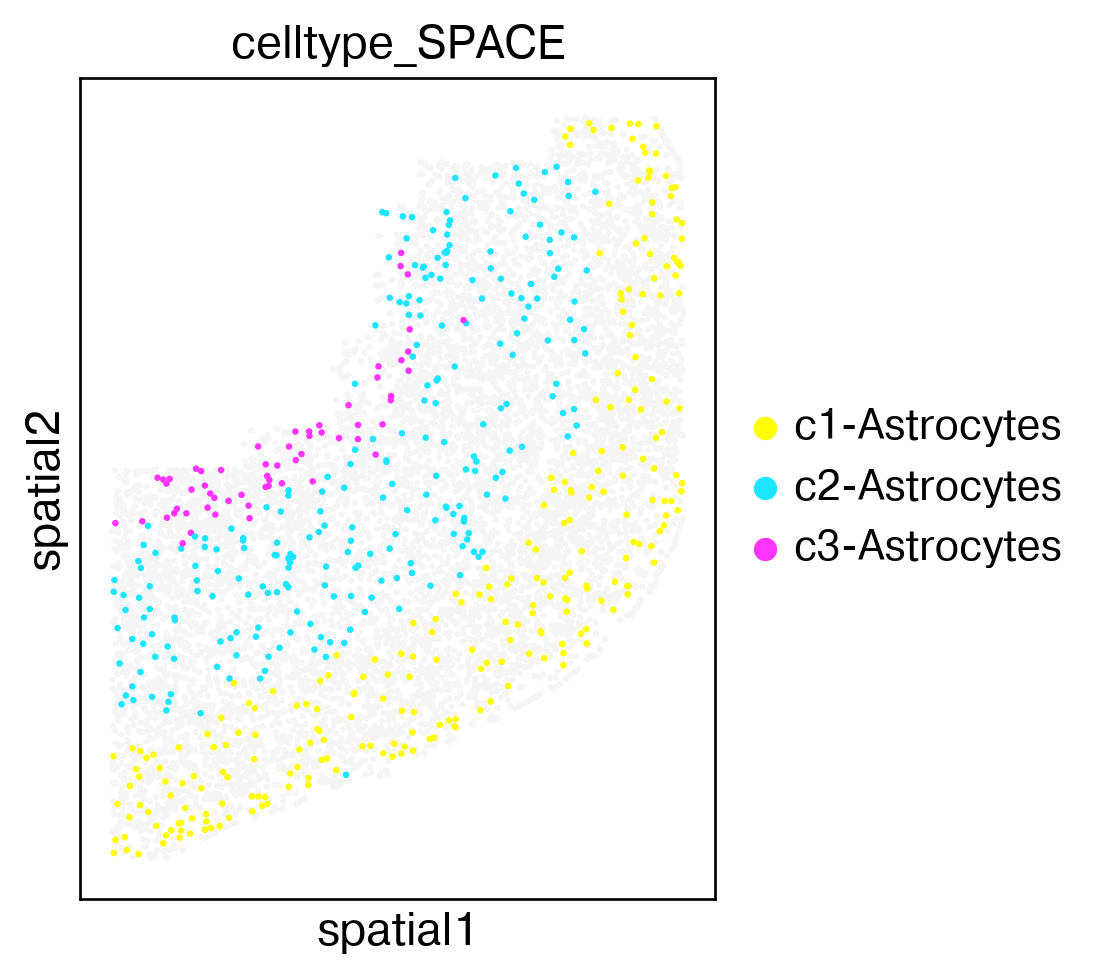

In [16]:
sc.pl.spatial(adata, spot_size=30,color='celltype_SPACE', groups=['c1-Astrocytes','c2-Astrocytes','c3-Astrocytes'], 
              na_color='whitesmoke', na_in_legend=False,save='_spatial_Astro.pdf')

## Oligodendrocytes subtypes

/home/zhangjinsong/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning:

Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.



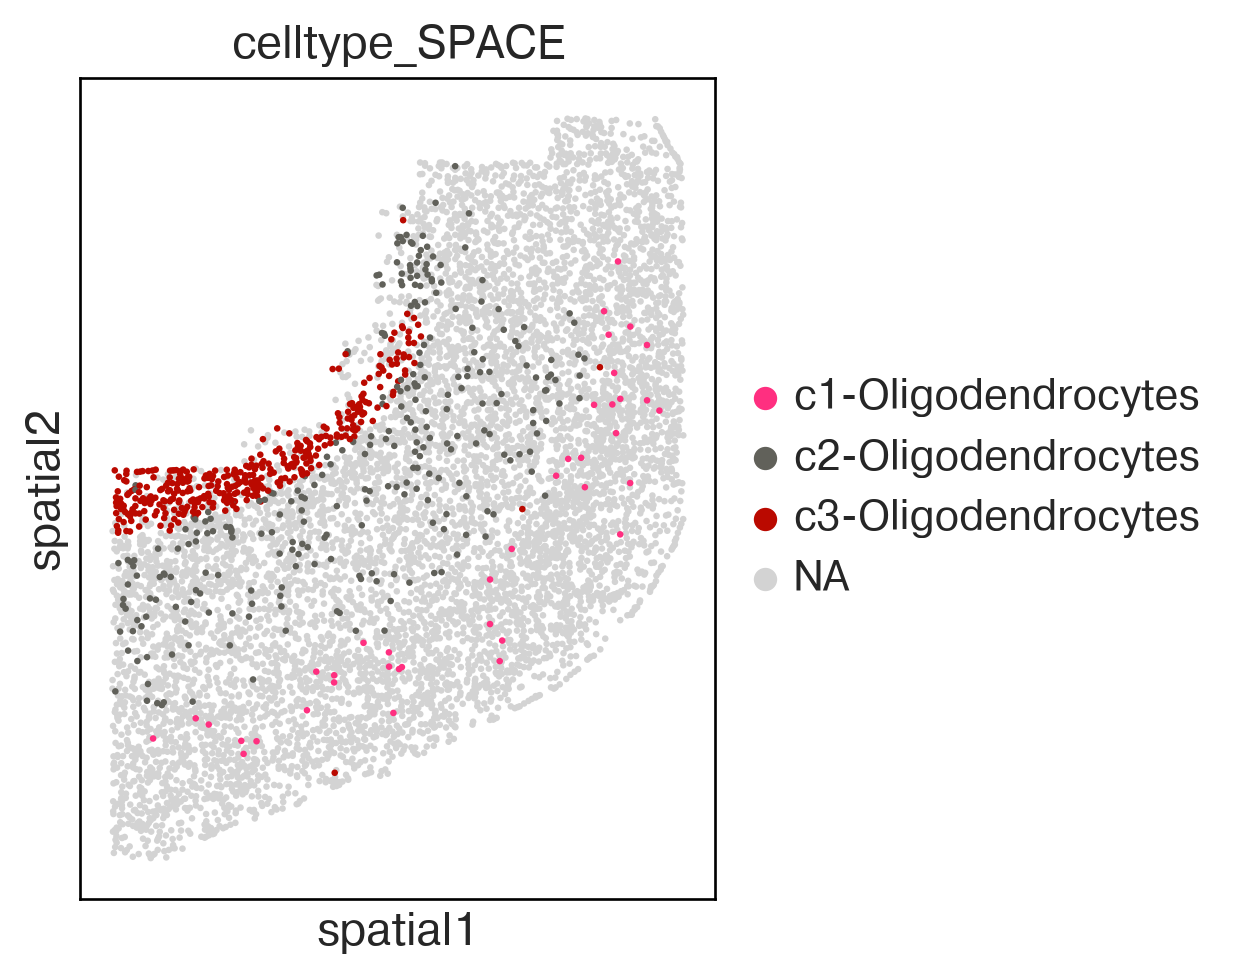

In [ ]:
sc.pl.spatial(adata, spot_size=30,color='celltype_SPACE', groups=['c1-Oligodendrocytes', 'c2-Oligodendrocytes', 'c3-Oligodendrocytes'],save='_spatial_Oligo_.pdf')